# Deep Time Series — Seq2Seq Multi-step Forecasting (LSTM)


## 0) Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


## 1) Données

In [2]:
np.random.seed(42)

n = 1200
t = np.arange(n)

# signal principal (y) = tendance + saison + bruit + événements
season = 2.5*np.sin(2*np.pi*t/50)
trend = 0.002*t
events = (t % 200 == 0).astype(float) * 2.0
noise = np.random.normal(0, 0.6, size=n)
y = 10 + trend + season + events + noise

# variables exogènes (features)
x1 = np.sin(2*np.pi*t/25) + np.random.normal(0, 0.2, size=n)   # ex: capteur vibration
x2 = (np.cos(2*np.pi*t/80) * 0.5) + np.random.normal(0, 0.15, size=n)  # ex: température
x3 = (t % 7)  # ex: jour de semaine (proxy)

df = pd.DataFrame({
    "ds": pd.date_range("2023-01-01", periods=n, freq="H"),
    "y": y,
    "x1": x1,
    "x2": x2,
    "x3": x3
})

df.head()


/tmp/ipython-input-4070624351.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "ds": pd.date_range("2023-01-01", periods=n, freq="H"),


,ds,y,x1,x2,x3
0,2023-01-01 00:00:00,12.298028,0.025045,0.391739,0
1,2023-01-01 01:00:00,10.232375,0.162809,0.524982,1
2,2023-01-01 02:00:00,11.014338,0.506213,0.411842,2
3,2023-01-01 03:00:00,11.840129,0.793207,0.445437,3
4,2023-01-01 04:00:00,11.071892,0.854100,0.726546,4


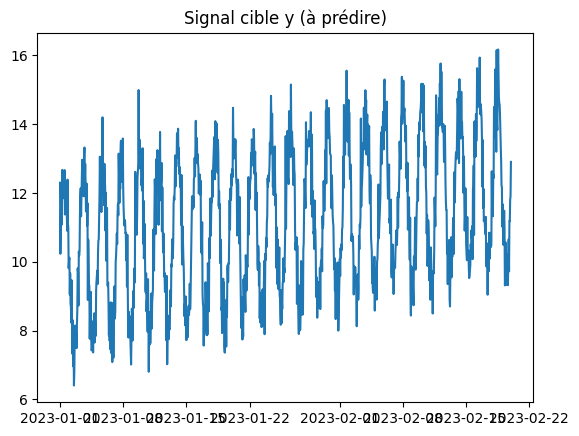

In [3]:
plt.figure()
plt.plot(df["ds"], df["y"])
plt.title("Signal cible y (à prédire)")
plt.show()


## 2) Paramètres + Split temporel


In [4]:
# Input window (lookback) et horizon de prévision
LOOKBACK = 72   # ex: 72h d'historique
H = 24          # ex: prédire les 24 prochaines heures

# Split temporel
train_ratio = 0.80
n_train = int(len(df) * train_ratio)

df_train = df.iloc[:n_train].copy()
df_test  = df.iloc[n_train:].copy()

features = ["y", "x1", "x2", "x3"]  # on inclut y dans l'entrée (auto-régressif)
target_col = "y"


## 3) Normalisation (important en deep time series)


In [5]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train[features].values)
test_scaled  = scaler.transform(df_test[features].values)

train_scaled.shape, test_scaled.shape


((960, 4), (240, 4))

## 4) Création des fenêtres (X) et des labels multi-step (Y)
- X: (samples, LOOKBACK, nb_features)
- Y: (samples, H) pour la cible y


In [6]:
def make_supervised_multistep(arr, lookback, horizon, target_index=0):
    X, Y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i-lookback:i, :])
        Y.append(arr[i:i+horizon, target_index])
    return np.array(X), np.array(Y)

target_index = features.index(target_col)

X_train, Y_train = make_supervised_multistep(train_scaled, LOOKBACK, H, target_index=target_index)
X_test,  Y_test  = make_supervised_multistep(test_scaled,  LOOKBACK, H, target_index=target_index)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((865, 72, 4), (865, 24), (145, 72, 4), (145, 24))

## 5) tf.data pipeline


In [7]:
BATCH = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_split = int(len(X_train) * 0.9)
val_ds = tf.data.Dataset.from_tensor_slices((X_train[val_split:], Y_train[val_split:])).batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds_small = tf.data.Dataset.from_tensor_slices((X_train[:val_split], Y_train[:val_split])).shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH).prefetch(tf.data.AUTOTUNE)


## 6) Modèle Deep — Seq2Seq LSTM (multi-step)
Encoder → RepeatVector(H) → Decoder → Dense(H)
> Résultat: on prédit **toute la trajectoire** des H prochains pas.


In [8]:
n_features = X_train.shape[-1]

model = models.Sequential([
    layers.Input(shape=(LOOKBACK, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),

    layers.RepeatVector(H),

    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),

    layers.TimeDistributed(layers.Dense(32, activation="relu")),
    layers.TimeDistributed(layers.Dense(1))
])

# sortie: (batch, H, 1) -> on va la reshaper en (batch, H)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 24, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

## 7) Entraînement (EarlyStopping + ReduceLROnPlateau)


In [9]:
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

history = model.fit(
    train_ds_small,
    validation_data=val_ds,
    epochs=50,
    callbacks=cb,
    verbose=1
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.8859 - val_loss: 1.2312 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.6544 - val_loss: 0.8562 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.5353 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.3850 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2537 - val_loss: 0.4946 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2394 - val_loss: 0.3509 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2068 - val_loss: 0.2427 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1972 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.1870 - val_loss: 0.1910 - learning_rate: 0.0010
Epoch 10/50
13/13

## 8) Prédictions + Remise à l'échelle
On revient à l'échelle originale de `y`.


In [11]:
# prédire (batch, H, 1) -> (N, H)
pred_scaled = model.predict(X_test, verbose=0).reshape(-1, H)

# Pour inverser le scaling uniquement sur y :
# StandardScaler: (x - mean)/std => x = scaled*std + mean
y_mean = scaler.mean_[target_index]
y_std  = np.sqrt(scaler.var_[target_index])

pred = pred_scaled * y_std + y_mean
true = Y_test * y_std + y_mean

pred.shape, true.shape


((145, 24), (145, 24))

## 9) Métriques (global + par horizon)


In [12]:
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# Global (tous les horizons mélangés)
mae_global = float(mean_absolute_error(true.flatten(), pred.flatten()))
rmse_global = rmse(true.flatten(), pred.flatten())

# Par pas (t+1, t+2, ..., t+H)
mae_steps = [float(mean_absolute_error(true[:,k], pred[:,k])) for k in range(H)]
rmse_steps = [rmse(true[:,k], pred[:,k]) for k in range(H)]

print("MAE global :", mae_global)
print("RMSE global:", rmse_global)
print("MAE t+1..t+H (5 premiers):", mae_steps[:5])
print("RMSE t+1..t+H (5 premiers):", rmse_steps[:5])


MAE global : 0.7004993520805197
RMSE global: 0.880270869072502
MAE t+1..t+H (5 premiers): [0.9803207845963466, 0.7061746100639327, 0.6291761443747215, 0.6174764714210748, 0.6125023291373783]
RMSE t+1..t+H (5 premiers): [1.252166401288464, 0.9106978455420196, 0.8051964734803141, 0.780679984333019, 0.7772446214780421]


## 10) Visualisation — une trajectoire multi-step


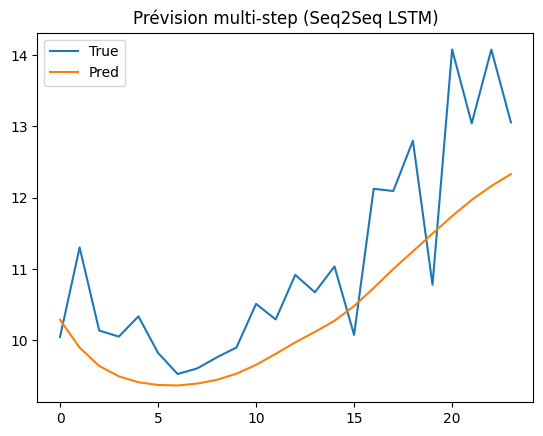

In [13]:
idx = 50  # change pour voir d'autres exemples

plt.figure()
plt.plot(range(H), true[idx], label="True")
plt.plot(range(H), pred[idx], label="Pred")
plt.title("Prévision multi-step (Seq2Seq LSTM)")
plt.legend()
plt.show()


## 11) Visualisation — erreur en fonction de l'horizon


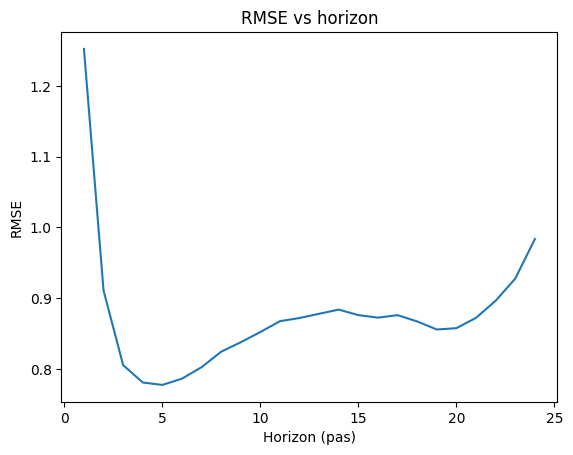

In [14]:
plt.figure()
plt.plot(range(1, H+1), rmse_steps)
plt.title("RMSE vs horizon")
plt.xlabel("Horizon (pas)")
plt.ylabel("RMSE")
plt.show()
